# Radar Waveforms and Range-Doppler Processing Assignment [Key] 
By Geoffrey Dolinger and Alexander Stringer

The followng is a learning assignment to gain a deeper understanding of the concepts presented in the Cognitive Radar Course Week 2.
The instructions here will include instructions and supporting code to teach the student to formulate the following:
1. Code transmit signal waveform and understand the parameters. 
3. Build a coherent processing interval for a pulsed-Doppler radar.
4. Embed the range and velocity information of a signal into a CPI.
5. Include Gaussian white noise (thermal) into our return signal. 
6. Perform the matched filter operation.
7. Complete Range-Doppler processing for embedded targets. 

Note: This version is the *key* and has full code included.  
If a student wishes to code this themselfs then please see the non-key version

In [2]:
# Imported packages
import numpy as np
import math
import random
import sys
import scipy
from scipy import constants
import matplotlib.pyplot as plt

# 0. Radar Parameters
The following includes the core parameters for an example radar signal:

In [89]:
# Transmitter Radar Parameters
F_0= 2e9                                         # Carrier Frequency (Hz) 
lambda_c = constants.c / F_0                     # wavelength given carrier frequency (s)
P_t = 300                                        # transmit power (Watts)
bandwidth = 30e6                                 # bandwidth of signal (Hz)
Tx = .5e-5                                       # transmit pulse (s)
Fs = 2*bandwidth                                 # Sample rate (Fs) in (Hz)
Ts = 1/Fs                                        # Sample pulse length (s)
Lx = round(Tx/Ts)                                # Sample count
t_x = np.ones((1,Lx))*np.linspace(0,Lx-1,Lx)*Ts  # time scale
gamma = bandwidth/Tx                             # gamma factor 
plot_pts = 750                                   # point count for plotting waveform
t_plot = np.linspace(0,1.5,plot_pts)*Tx          # time variable for plotting waveforms

# 1. Continuous wave funtions
The first set of waveforms will be to create and plot a continuous wave and the common linear frequency modulated (LFM) waveform.

A complex baseband waveform can be represented as :
$$
    s(t) = a(t) exp(j \theta (t))
$$
where the envelop is $ a(t) $ and the phase function is $ \theta(t) $.

The full waveform includes the carrier information and has the form: 
$$
    x(t) = a(t) sin(2 \pi F_0 t +f(t))
$$
For the following section lets code the full waveform and complex baseband waveform for a constant frequency: $f(t) = 0$, $ \theta(t) = 0 $, and $ a(t) = \begin{cases} \sqrt{P_t} & \text{for } 0 \leq t \leq \tau \\ 0 & \text{otherwise} \end{cases}$


In [76]:
#Code for the transmit signal:
x_amp = np.sqrt(P_t)                                    # transmit amplitude component
x_full = x_amp*np.sin(2*np.pi*F_0*t_plot)               # full waveform code
x_full = np.where(t_plot>Tx, 0, x_full)                 # Set the points outside the transmit time to zeros
s_TX = x_amp * np.exp(1j*0)*np.ones(plot_pts)           # complex baseband code
s_TX = np.where(t_plot>Tx, 0, s_TX)                     # Set the points outside the transmit time to zeros

c:\ProgramData\Anaconda3\envs\D70cur\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Amplitude')

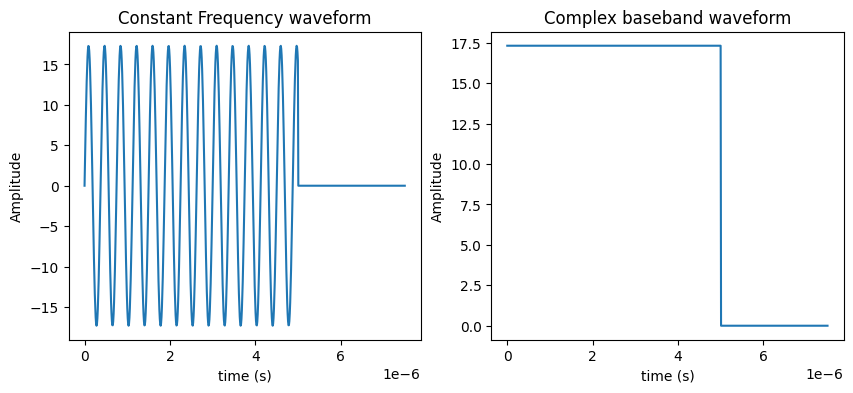

In [77]:
#Plotting code for the signal
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t_plot, x_full)
ax[0].set_title('Constant Frequency waveform')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(t_plot, s_TX)
ax[1].set_title('Complex baseband waveform')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Amplitude')

Now we will plot a linear frequency modulated (LFM) waveform with a positive chirp rate.

A complex baseband waveform can be represented as :
$$
    s(t) = a(t) exp(j \theta (t))
$$
where the envelop is $ a(t) $ and the phase function is $ \theta(t) $.

The full waveform includes the carrier information and has the form: 
$$
    x(t) = a(t) sin(2 \pi F_0 t +f(t))
$$
For the following section lets code the full waveform and complex baseband waveform for a constant frequency: 
$ f(t) = (\frac{\beta}{T_x}t) $, 

$ \theta(t) = (\frac{\beta}{2 T_x}t^2) $ and $ a(t) = \begin{cases} \sqrt{P_t} & \text{for } 0 \leq t \leq \tau \\ 0 & \text{otherwise} \end{cases}$

Where the chirp rate is $\gamma = \frac{\beta}{T_x}$ 

In [90]:
gamma = bandwidth/Tx                                            # Chirp rate
lfm_freq = (gamma*t_plot)                                       # LFM frequency function
x_lfm_full = x_amp*np.sin(2*np.pi*F_0*t_plot+lfm_freq)          # LFM full waveform code
x_lfm_full = np.where(t_plot>Tx, 0, x_lfm_full)                 # Set the points outside the transmit time to zeros
lfm_phase = (gamma/2*t_plot**2)                                 # LFM phase function
s_lfm_TX = x_amp * np.exp(1j*lfm_phase)                         # LFM complex baseband code
s_lfm_TX = np.where(t_plot>Tx, 0, s_lfm_TX)                     # Set the points outside the transmit time to zeros

Text(0, 0.5, 'Amplitude')

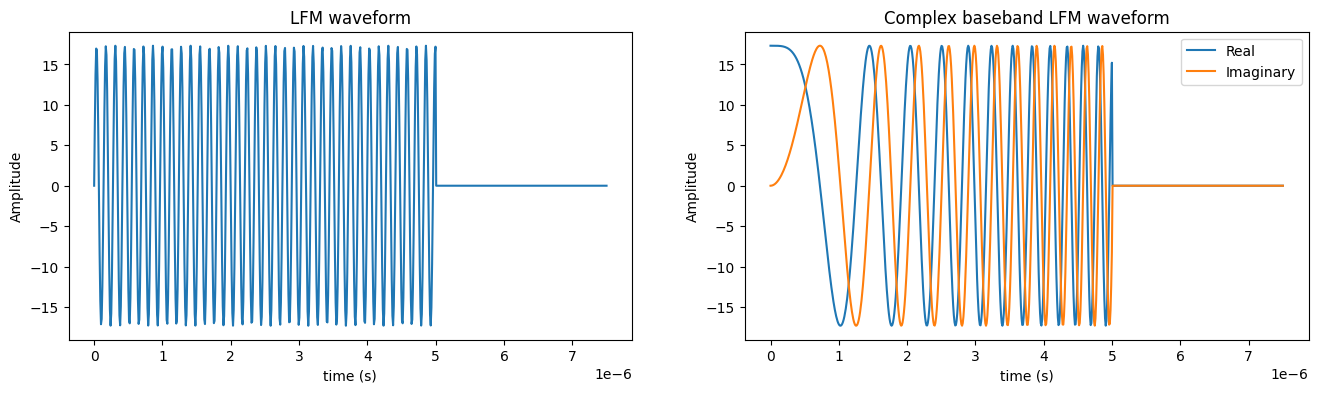

In [91]:
#Plotting code for the signal
fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(t_plot, x_lfm_full)
ax[0].set_title('LFM waveform')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(t_plot, np.real(s_lfm_TX),label = 'Real')
ax[1].plot(t_plot, np.imag(s_lfm_TX),label = 'Imaginary')
ax[1].legend()
ax[1].set_title('Complex baseband LFM waveform')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Amplitude')

Although it is important to understand the full waveform, the carrier in important to propogate energy, but the complex baseband is the component that includes the signal information.  

Additionally, this baseband information is seperated by the receiver hardware and is the form of the data used for most radar signal processing 

# 2. Coherent Processing Interval
The following will take the LFM produced above and build a coherent processing interval (CPI). 

A CPI in $m$ samples of tranmit signal from a pulsed-Doppler radar.  Effectively, this creates a data matrix transmited and received that is some sample length by the $m$ samples.  
An important parameter for pulsed-Doppler radar is the period of time that the radar "listens" befor transmitting again.  This is represented with the pulse repitition frequency/inteval. 
This first step will rebuild our LFM baseband as a data cube of $m$ samples and set our PRI/PRF. 

In [80]:
M = 128                                                     # Number of samples
PRF = 8500                                                  # pulse repitition frequency
PRI = 1/PRF                                                 # pulse repitition interval
m = np.ones((1,M))*np.linspace(-M/2,M/2-1,M)                # axis of samples centered at 0

x_phase = (gamma/2*t_x**2)                                  # basebande phase function
x_TX = np.tile((x_amp * np.exp(1j*x_phase)).T,(1,M))        # transmit CPI
x_TX_single = x_amp * np.exp(1j*x_phase)                    # single transmit for version for later processing

The systems has limitations between the range resolution and the Doppler/velocity resolution and the maximum values for each based on the selection of transmit pulse length, PRF/PRI, bandwidth, the carrier wavelength, and sample count.  

Range limits: $R_{min} = \frac{T_x}{2}c$ and $R_{max} = \frac{PRI-T_x}{2}c$

Range resolution: $R_{res}=\frac{c}{2 \beta}$

Velocity limits: $v_{min} = \frac{-PRI}{4 \lambda}$ and $v_{max} = \frac{PRI}{4 \lambda}$

Velocity resolution: $v_{res}=\frac{\lambda}{2 m PRI}$

In [92]:
Rmin_sys = Tx/2*constants.c                                 # minimum range given radar settings                                                                             
Rmax_sys = (PRI-Tx)/2*constants.c                           # maximum range given radar settings  

R_res = constants.c/(2*bandwidth)                           # range resolution given radar settings  

vmin_sys = -PRF/4*lambda_c                                  # minimum velocity given radar settings                                                   
vmax_sys = PRF/4*lambda_c                                   # maximum velocity given radar settings                                                 
                                                        
FD_res = 1/(M*PRI)                                          # Doppler resolution given radar settings                                                      
v_res = FD_res*lambda_c/2                                   # Velocity resolution given radar settings 

print("Range Max: %0.2f, Range Min: %0.2f"%(Rmax_sys,Rmin_sys))
print("Range Resolution: %0.2f"%(R_res))
print("Velocity Max:  %0.2f,, Velocity Min: %0.2f"%(vmax_sys,vmin_sys))
print("Velocity Resolution: %0.2f"%(v_res))

Range Max: 16885.37, Range Min: 749.48
Range Resolution: 5.00
Velocity Max:  318.53,, Velocity Min: -318.53
Velocity Resolution: 4.98


# 3. Target information and return signal simulation 

Now that the pulsed-Doppler transmit signal exists we will simulated multiple targets in our radar space. 

Even though you can process the full range from the system minimum  to maximum it is common to only process a subset. Therefore, we will set a range minimum ($R_{min}$) and maximum ($R_{max}$) for our system. This will correspond to time values: $t_i = \frac{2 R_{min}}{c}$ and $t_i = \frac{2 R_{max}}{c}+T_x$. Given this span we have a number of sample givenour sampling rate: $L_{ADC} = \frac{t_f-t_i}{T_s}+1$. This enables the establishment of a fast time axis of length $L_{ADC}$: $t_{fast} = [t_i, t_i+Ts, t_i+2Ts, ..., t_f-Ts, t_f]$

For the targets we can include any number of targets which each need three parameters: true range ($R_{tgt}$), true velocity ($v_{tgt}$), and the radar cross section ($\sigma_{tgt}$). 

The target range will create a power increase as a time $\tau = \frac{2 (R_{tgt}-v_{tgt}*m*PRI)}{c}$ (velocity is used given the minor movement between samples, this assumes a linear movement during the CPI) and impose a Doppler frequency: $F_D = \frac{2 v_{tgt}}{\lambda}$


In [ ]:
Rmin = 5e3                                                              # Radar view window: range minimum                                                       
Rmax = 15.0e3                                                           # Radar view window: range maximum                                                          
t_i = 2*Rmin/constants.c                                                # Minimum listining time                                                        
t_f = 2*Rmax/constants.c +Tx                                            # Maximum listining time 
L_ADC = round((t_f-t_i)/Ts+1)                                           # Received points given time and sampling rate
t_fast =np.ones((1,L_ADC))*np.linspace(t_i,t_f,L_ADC)                   # fast time axis for plotting
R_axis =constants.c *t_fast/2                                           # Range axis for plotting

## Set these to anything between Rmin and Rmax, and between vmin_sys and vmax_sys
R_tgt = np.expand_dims(np.array([12400.0, 9050.0, 6840.0]), axis=1)     # N targets in the space (Range)
v_tgt = np.expand_dims(np.array([-240, 70, 130]), axis=1)               # N targets in the space (Velocity)
sigma_tgt = np.expand_dims(np.array([10, 15, 10]), axis=1)              # N targets in the space (RCS)
## -----------------------------------------------------------------------------
Range = R_tgt - v_tgt *m* PRI                                           # Linear ranges given samples
tau = 2*Range/constants.c                                               # Linear time across CPI
F_D = 2*v_tgt/lambda_c                                                  # Doppler shift given target relative velocity

In order to simulate the targets we will need to calculate the return power and then utilize the fast Fourier transform (FFT) to insert the tau and doppler shift information. This is typically looped for each target being simulated.  
- The ratio of return power to transmit power and equivalent amplitude voltage ratio ($\alpha$) is calculated with the radar range equation: 
$$
    \frac{P_r}{P_t} = \frac{G^2 \lambda^2 \sigma}{(4 \pi)^3 R^4} \text{ where } \alpha = \sqrt{\frac{P_r}{P_t}}
$$

- The range information is added in the frequency domain with the following steps: 
1. Perform the FFT and FFT shift to transmit signal:  $\mathscr{L}(x_{tx}(t,m)) = X_{tx}(f,m) $ 
2. Build the frequency axis ($f$) of length $L_{ADC}$ from $-F_s/2$ to $F_s/2$.  
3. Time-shift in the frequency domain at $\tau$:  $X_{rx}(f,m) = X_{tx}(f) e^{-j 2 \pi f (\tau(m)-t_i) }$

- The Doppler information is included in the time domain: 
1. Perform the inverse FFT-shift and inverse FFT:  $\mathscr{L}^{-1}(X_{rx}(f,m)) = x_{rx}(t,m) $
2. Finally, apply the Doppler shift and alpha scaling in the time domain using: $y(t,m) = x_{rx}(t,m) \alpha \exp(j2\pi F_Dt)$

This is added together for each target.  

In [93]:
G = 100                                                                                         # Gain of radar antenna
alpha = np.sqrt((G**2*lambda_c**2*sigma_tgt)/(((4*np.pi)**3)*(R_tgt**4)))                       # Power ratio for received signal
f = np.ones((1,L_ADC))*np.linspace(-Fs/2,(L_ADC-1)*Fs/L_ADC-Fs/2,L_ADC)                         # frequency domain axis given sampling frequency                                         
X_TX_f_single = np.fft.fftshift(np.fft.fft(x_TX_single,L_ADC))                                  # Frequency domain of transmit signal

x_RX_TDshift = np.zeros((L_ADC,M),dtype=np.complex_)                                            # Placeholder for the received CPI
for i in range(len(R_tgt)):                                                                     # loop through targets
    X_RX_tshift = np.tile(X_TX_f_single.T,(1,M))*np.exp(-1j*2*np.pi*np.dot(f.T,np.expand_dims(tau[i,:],axis=0)-t_i))    # time shift in frequency domain
    X_RX_F = X_RX_tshift*alpha[i]*np.tile(np.exp(1j*2*np.pi*F_D[i]*m*PRI),(L_ADC,1))            # Doppler shift and power scale
    x_RX = np.fft.ifft(np.fft.ifftshift(X_RX_F,0),L_ADC,0)                                      # return to time domain 
    x_RX_TDshift = x_RX_TDshift+x_RX                                                            # add the target info to the return CPI

# 4. Thermal Noise Simulation

It is important to now include the thermal noise component:
The noise Power is determined with: 
$$
    P_n = k_b \beta F T_s
$$
For noise power the important variables are Boltzmann's constant ($k_b$), ($\beta$) is the signal bandwidth, ($F$) is the noise figure, and ($T_s$) is system temperature.

To implement the noise signal to add to the return values we will generate independent Gaussian noise for the real and imaginary components.  
$$
     n(t,m) = \sqrt{\frac{P_n}{2}} \mathcal{N}[0,1](t,m) + j  \mathcal{N}[0,1](t,m)
$$

In [94]:
kB = 1.38e-23                                                                                       # Boltzmann constant
Temp = 290                                                                                          # Typical system temperature (K)
Fsys = 4                                                                                            # System loss 
Pn = kB*Temp*Fs*Fsys                                                                                # noise power

n_thermal = np.sqrt(Pn/2)*((np.random.normal(0,1,(L_ADC,M))) + 1j*np.random.normal(0,1,(L_ADC,M)))  # Gaussian white noise for full CPI
x_RX_TDshift = x_RX_TDshift + n_thermal                                                             # Add noise to CPI

At this point we now have simulated IQ data with multple targets and thermal noise! Real data will have other forms of interference (clutter and/or jamming signals), but that is a deeper topic for later. This is the point where the IQ data could be processed with multiple detection algorithms.  For this assignment we will use the matched filter and conduct range-Doppler processing. 

# 5. Matched Filter

Now that we have a formulation for the return signal, it is important to address the most common processing method performed on return signals, called the matched filter. The matched filter is designed to maximize the signal-to-noise ratio at some time for a given signal. For a reflected transmit signal within a return signal, a matched filter is designed to be a time revered, conjugated copy of the transmitted waveform. The time and frequency versions of the matched filter are shown in the following equations: 
$$
        h(t) = \alpha x^*(T_M -t)\\
        H(F) = \alpha X^*(F)\exp{-j2\pi F T_m}
$$
Where $T_M$ is the time where we want to maximize the SNR and typically is equal or greater than the transmit pulse ($T_M \geq T_p$) in order to maintain causality.
The term $\alpha$ is a scaling constant that is usually set to 1 during the analysis of signal returns. The filtering process is a convolution of the signal and the filter. In practice, matched filter processing is usually done in the frequency domain as the convolution corresponds to multiplication. The process for applying the matched filter is the following steps: 
1. Given the time based return signal $y(t,m)$.
2. Complete a FFT and an FFT shift for the return signal of $y(t,m) \rightarrow Y(f,m)$ 
3. Generate the matched filter by taking the conjugate of the transmit signal and reversing the signal order $h(t) =x^*(-t)$.
4. Convert the matched filter to frequency domain with FFT and FFT shift. ($h(t) \rightarrow H(f)$)
5. Multiply the matched filter and the return signal in frequency domain:
    $Y_m(f,m) = Y(f,m)\cdot H(f)$
6. Finally, return to the time domain with an inverse FFT shift and inverse FFT: $Y_m(f,m) \rightarrow y_m(t,m)$   

In [95]:
X_RX = np.fft.fftshift(np.fft.fft(x_RX_TDshift,L_ADC,0),0)              # Shift to the frequency domain as convolution is multiplication
h_m = np.roll(x_TX_single[::-1],Lx)                                     # matched filter = time reverse tansmit signal
H_m = np.fft.fftshift(np.fft.fft(h_m,L_ADC))                            # Frequency version of matched filter
Y_m =  np.tile(np.conj(H_m.T),(1,M))*X_RX                               # Conjugate then multiply in Freq Domain         
y_m = np.fft.ifft(np.fft.ifftshift(Y_m,0),L_ADC,0)                      # time domain matched filter

Text(0, 0.5, 'Range Bin')

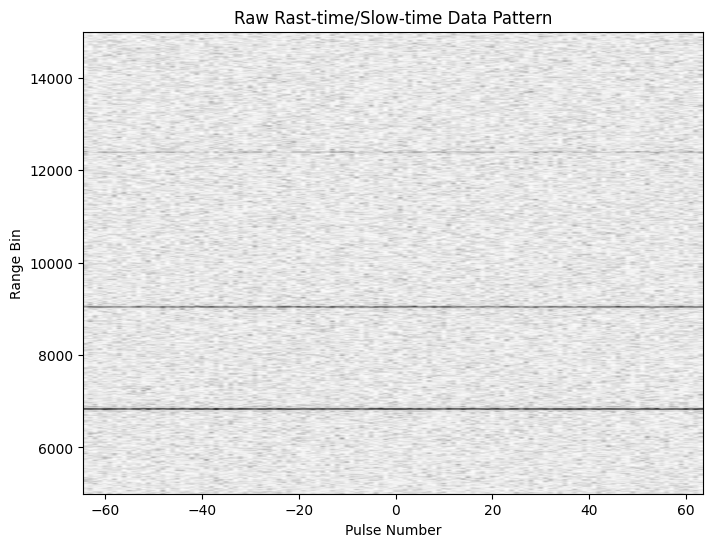

In [ ]:
# Plotting Code
R_ind = np.argmin(abs(R_axis-Rmax)) 
R_delta = R_axis[0,1]-R_axis[0,0]
fig, ax = plt.subplots( figsize=(8,6))

ax.imshow(abs(y_m[0:R_ind+1,:]),aspect='auto',cmap='gray_r',origin='lower',extent = [m[0,0]-.5,m[0,-1]+.5,R_axis[0,0]-R_delta/2,R_axis[0,R_ind]+R_delta/2])
ax.set_title('Raw Fast-time/Slow-time Data Pattern')
ax.set_xlabel('Pulse Number')
ax.set_ylabel('Range Bin')

# 6. Range-Doppler Processing

Considering that a target of interest will delay the signal in time given its range and induce a Doppler shift due to its relative velocity, we would want to be able to distinguish targets given both features. This process is called range-Doppler processing as we will take the return CPI $y(t,m)$ and process the range from the time axis (fast time) and the velocity/Doppler information from the samples $m$ (slow time).

For the fast time axis you use a filter method. For the slow time axis we will use the FFT and a FFT shift to translate the samples into the frequency domain. The result will display range and Doppler cells in two different axis that visualize targets, noise, and clutter.

In [97]:
Nfft_Fd = 128                                           # Range Doppler points for Doppler axis, Nfft_Fd >=M
RD_processed0 = np.fft.fft(Y_m,Nfft_Fd,1)               # Perfrom an FFT in Doppler axis in frequency domain 
RD_processed = np.fft.ifft(RD_processed0,axis=0)        # Return to time domain
RD_norm = np.fft.fftshift(RD_processed,1)               # Shift to center at 0 in Doppler


Target 1: Range = 12400 m, Velocity= -240.00 m/s 
Target 2: Range = 9050 m, Velocity= 70.00 m/s 
Target 3: Range = 6840 m, Velocity= 130.00 m/s 


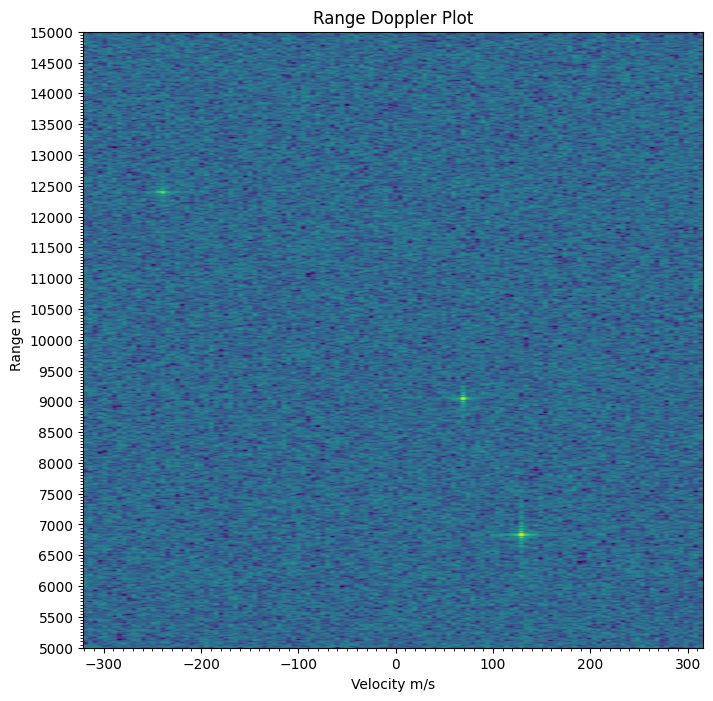

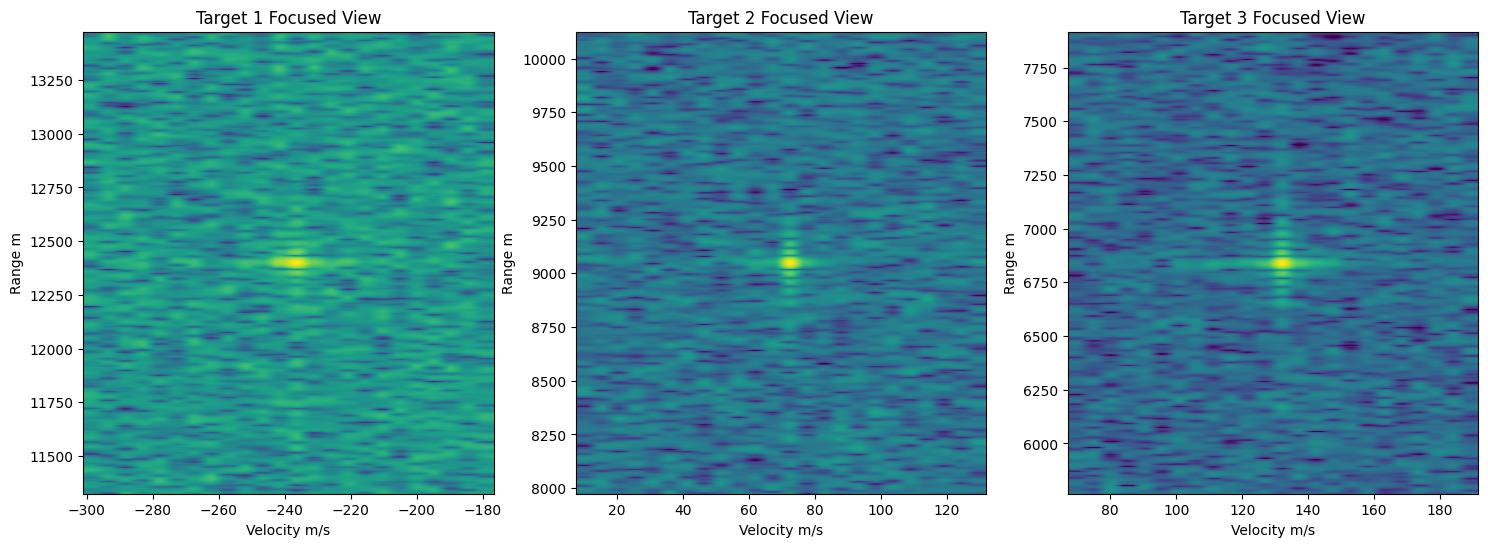

In [98]:
#Plotting code for visualizing final RD processed plots

Fd_axis = np.ones((1,Nfft_Fd))*np.linspace(-PRF/2,PRF/2-PRF/Nfft_Fd,Nfft_Fd) 
V_axis = Fd_axis/2*lambda_c
V_delta = abs(V_axis[0,1]-V_axis[0,0])

fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(10*np.log10(abs(RD_norm[0:R_ind+1,:])/np.max(abs(RD_norm[0:R_ind+1,:]))),aspect='auto',origin='lower',extent = [V_axis[0,0]-V_delta/2,V_axis[0,-1]+V_delta/2,R_axis[0,0]-R_delta/2,R_axis[0,R_ind]+R_delta/2], vmin = -30)
ax.set_title('Range Doppler Plot')
ax.set_xlabel('Velocity m/s')
ax.set_ylabel('Range m')
ax.set_yticks(np.arange(R_axis[0,0], R_axis[0,R_ind], 500))
ax.set_yticks(np.arange(R_axis[0,0], R_axis[0,R_ind], 50), minor=True)
ax.set_xticks(np.arange(-320, 320, 10), minor=True)

fig, ax = plt.subplots(1,len(R_tgt),figsize=(6*len(R_tgt),6))
for i in range(len(R_tgt)):
    R_tgt_ind = np.argmin(abs(R_axis-R_tgt[i]))
    v_tgt_ind = np.argmin(abs(V_axis-v_tgt[i]))
    R_window = [np.max((0,R_tgt_ind-int(len(R_axis[0])/10))), np.min((len(R_axis[0]-1),R_tgt_ind+int(len(R_axis[0])/10)))]
    v_window = [np.max((0,v_tgt_ind-int(len(V_axis[0])/10))), np.min((len(V_axis[0]-1),v_tgt_ind+int(len(V_axis[0])/10)))]
    ax[i].imshow(10*np.log10(abs(RD_norm[R_window[0]:R_window[1],v_window[0]:v_window[1]])/np.max(abs(RD_norm[R_window[0]:R_window[1],v_window[0]:v_window[1]]))),aspect='auto',origin='lower',extent = [V_axis[0,v_window[0]]-V_delta/2,V_axis[0,v_window[1]]+V_delta/2,R_axis[0,R_window[0]]-R_delta/2,R_axis[0,R_window[1]]+R_delta/2], vmin = -30)
    ax[i].set_title("Target %0.0f Focused View"%(i+1))
    ax[i].set_xlabel('Velocity m/s')
    ax[i].set_ylabel('Range m')

for i in range(len(R_tgt)):
    print("Target %0.0f: Range = %0.0f m, Velocity= %0.2f m/s "%(i+1, R_tgt[i], v_tgt[i]))

We should see the targets at the range and velocity bin close to the real values set earlier.  

You can experiment with changing paramters and target details for additional understanding.  